# Exploratory Data Analysis

In [48]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import networkx as nx
from scipy.cluster import hierarchy
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sunburst Plotty chart
import plotly.graph_objects as go
import random


# Display all dataframe columns
#pd.set_option('display.max_columns', None)

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# We are using whitegrid style for our seaborn plots. This is the most basic one
sns.set_style(style = 'whitegrid')

In [2]:
# Directory with the downloaded data files 
raw_data_dir = Path('../data/raw')

## Training.csv

In [3]:
# Load the dataset
training = pd.read_csv(raw_data_dir / 'Training.csv')
df = training.copy()

In [4]:
# Show the shape
df.shape

(4920, 134)

In [5]:
# Show first 5 rows
df.head(5)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [6]:
# How many columns per data type are there?
df.dtypes.value_counts()

int64      132
object       1
float64      1
Name: count, dtype: int64

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 134 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    itching                         4920 non-null   int64  
 1    skin_rash                       4920 non-null   int64  
 2    nodal_skin_eruptions            4920 non-null   int64  
 3    continuous_sneezing             4920 non-null   int64  
 4    shivering                       4920 non-null   int64  
 5    chills                          4920 non-null   int64  
 6    joint_pain                      4920 non-null   int64  
 7    stomach_pain                    4920 non-null   int64  
 8    acidity                         4920 non-null   int64  
 9    ulcers_on_tongue                4920 non-null   int64  
 10   muscle_wasting                  4920 non-null   int64  
 11   vomiting                        4920 non-null   int64  
 12   burning_micturitio

In [8]:
# The last column has null values only and can be safely removed
unnamed_column_filter = df.filter(['Unnamed: 133'])
df.drop(unnamed_column_filter, inplace=True, axis=1)
df.shape

(4920, 133)

In [9]:
# New directory for the processed data files 
processed_data_dir = Path('../data/processed')

def save_processed(df, filename):
    # Save the deduplicate training data in its own file
    df.to_csv(processed_data_dir / filename, index=False)
    
# We don't need to keep the original 'training' with the unnamed column
training = df.copy() 

# Save training dataset without the 'Unnamed: 133' column
save_processed(training, 'training.csv')

In [10]:
# Other missing values?
df.isnull().sum().sum()

0

In [11]:
def check_all_int64_variables_are_binary(df):
    is_binary = ((df.select_dtypes(include='int64') == 0) | (df.select_dtypes(include='int64') == 1)).all()
    all_binary = is_binary.all()
    if (all_binary):
        print("All int64 columns contain only 0 and 1.")
    else:
        non_binary_columns = is_binary[~is_binary].index
        print("Columns with values other than 0 and 1:", non_binary_columns.tolist())
        
    assert all_binary
    
check_all_int64_variables_are_binary(df)


All int64 columns contain only 0 and 1.


In [12]:
def describe_binary(df):
    binary_cols = df.select_dtypes(include='int64').columns
    binary_summary = df[binary_cols].agg(['count', 'sum', 'mean'])
    binary_summary = binary_summary.T  # Transpose for better readability
    binary_summary['count_ones'] = binary_summary['sum'].astype(int)
    binary_summary['percent_ones'] = (binary_summary['count_ones'] / binary_summary['count']) * 100
    binary_summary['count_zeros'] = (binary_summary['count'] - binary_summary['count_ones']).astype(int)
    binary_summary['percent_zeros'] = (1 - binary_summary['mean']) * 100
    return binary_summary[['count', 'count_ones', 'percent_ones', 'count_zeros', 'percent_zeros']]

describe_binary(df).sort_values(by='percent_ones')

,count,count_ones,percent_ones,count_zeros,percent_zeros
fluid_overload,4920.0,0,0.000000,4920,100.000000
foul_smell_of urine,4920.0,102,2.073171,4818,97.926829
sunken_eyes,4920.0,108,2.195122,4812,97.804878
swollen_blood_vessels,4920.0,108,2.195122,4812,97.804878
extra_marital_contacts,4920.0,108,2.195122,4812,97.804878
...,...,...,...,...,...
nausea,4920.0,1146,23.292683,3774,76.707317
loss_of_appetite,4920.0,1152,23.414634,3768,76.585366
high_fever,4920.0,1362,27.682927,3558,72.317073
vomiting,4920.0,1914,38.902439,3006,61.097561


In [13]:
def column_sparsity(df):
    total_rows = len(df)
    zero_count = (df == 0).sum()  # Count the number of zeros in each column
    sparsity = (zero_count / total_rows).to_frame()
    sparsity.columns = ['sparsity']
    return sparsity

column_sparsity(df).sort_values(by='sparsity')

,sparsity
prognosis,0.000000
fatigue,0.607317
vomiting,0.610976
high_fever,0.723171
loss_of_appetite,0.765854
...,...
watering_from_eyes,0.978049
muscle_wasting,0.978049
shivering,0.978049
foul_smell_of urine,0.979268


In [14]:
df.describe(include='object')

,prognosis
count,4920
unique,41
top,Fungal infection
freq,120


In [15]:
# How many observations per target variable?
df['prognosis'].value_counts().sort_values(ascending=False)

prognosis
Fungal infection                           120
Allergy                                    120
GERD                                       120
Chronic cholestasis                        120
Drug Reaction                              120
Peptic ulcer diseae                        120
AIDS                                       120
Diabetes                                   120
Gastroenteritis                            120
Bronchial Asthma                           120
Hypertension                               120
Migraine                                   120
Cervical spondylosis                       120
Paralysis (brain hemorrhage)               120
Jaundice                                   120
Malaria                                    120
Chicken pox                                120
Dengue                                     120
Typhoid                                    120
hepatitis A                                120
Hepatitis B                                120
Hep

All categories have the exact same number of observations. That's unusual. 

Maybe the data is synthetic? Or perhaps it was pre-processed to deal with imbalanced categories?

In [16]:
# Look for duplicates
df.duplicated().sum()

4616

In [17]:
def duplicate_count(df):
    total_rows = len(df)
    duplicate_rows = df.duplicated().sum()
    duplicate_percentage = (duplicate_rows / total_rows) * 100

    print(f"Number of duplicate rows: {duplicate_rows}")
    print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%")
    
duplicate_count(df)    

Number of duplicate rows: 4616
Percentage of duplicate rows: 93.82%


That's a lot of duplicated observations!

In [18]:
# After removing duplicates, what's the count per prognosis?
deduplicated_training = df.drop_duplicates()
deduplicated_training['prognosis'].value_counts().sort_values()

prognosis
Fungal infection                            5
Heart attack                                5
Allergy                                     5
Paralysis (brain hemorrhage)                5
Urinary tract infection                     5
AIDS                                        5
Acne                                        5
Gastroenteritis                             5
Drug Reaction                               6
Hypertension                                6
Dimorphic hemmorhoids(piles)                6
Impetigo                                    6
Arthritis                                   6
Cervical spondylosis                        6
Bronchial Asthma                            7
GERD                                        7
Psoriasis                                   7
Peptic ulcer diseae                         7
Hepatitis C                                 7
(vertigo) Paroymsal  Positional Vertigo     7
Osteoarthristis                             7
Alcoholic hepatitis     

After removing the duplicates, there is only between 5 and 10 rows per label. It becomes a very small dataset.

In [19]:
save_processed(deduplicated_training, 'deduplicated-training.csv')

## Testing.csv

In [20]:
# Load the dataset
testing  = pd.read_csv(raw_data_dir / 'Testing.csv')
df = testing.copy()

In [21]:
# Show the shape
df.shape

(42, 133)

In [22]:
# Display the first few rows
df.head(5)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [23]:
# How many columns per data type are there?
df.dtypes.value_counts()

int64     132
object      1
Name: count, dtype: int64

In [24]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 133 columns):
 #    Column                          Non-Null Count  Dtype 
---   ------                          --------------  ----- 
 0    itching                         42 non-null     int64 
 1    skin_rash                       42 non-null     int64 
 2    nodal_skin_eruptions            42 non-null     int64 
 3    continuous_sneezing             42 non-null     int64 
 4    shivering                       42 non-null     int64 
 5    chills                          42 non-null     int64 
 6    joint_pain                      42 non-null     int64 
 7    stomach_pain                    42 non-null     int64 
 8    acidity                         42 non-null     int64 
 9    ulcers_on_tongue                42 non-null     int64 
 10   muscle_wasting                  42 non-null     int64 
 11   vomiting                        42 non-null     int64 
 12   burning_micturition             42 n

In [25]:
# Missing values?
df.isnull().sum().sum()

0

In [26]:
check_all_int64_variables_are_binary(df)

All int64 columns contain only 0 and 1.


In [27]:
describe_binary(df).sort_values(by='percent_ones')

,count,count_ones,percent_ones,count_zeros,percent_zeros
fluid_overload,42.0,0,0.000000,42,100.000000
cramps,42.0,1,2.380952,41,97.619048
passage_of_gases,42.0,1,2.380952,41,97.619048
continuous_feel_of_urine,42.0,1,2.380952,41,97.619048
foul_smell_of urine,42.0,1,2.380952,41,97.619048
...,...,...,...,...,...
nausea,42.0,10,23.809524,32,76.190476
loss_of_appetite,42.0,10,23.809524,32,76.190476
high_fever,42.0,12,28.571429,30,71.428571
fatigue,42.0,17,40.476190,25,59.523810


In [28]:
column_sparsity(df).sort_values(by='sparsity')

,sparsity
prognosis,0.000000
fatigue,0.595238
vomiting,0.595238
high_fever,0.714286
loss_of_appetite,0.761905
...,...
bloody_stool,0.976190
pain_in_anal_region,0.976190
weakness_in_limbs,0.976190
bruising,0.976190


In [29]:
df.describe(include='object')

,prognosis
count,42
unique,41
top,Fungal infection
freq,2


In [30]:
# How many observations per target variable?
df['prognosis'].value_counts().sort_values(ascending=False)

prognosis
Fungal infection                           2
Allergy                                    1
GERD                                       1
Chronic cholestasis                        1
Drug Reaction                              1
Peptic ulcer diseae                        1
AIDS                                       1
Diabetes                                   1
Gastroenteritis                            1
Bronchial Asthma                           1
Hypertension                               1
Migraine                                   1
Cervical spondylosis                       1
Paralysis (brain hemorrhage)               1
Jaundice                                   1
Malaria                                    1
Chicken pox                                1
Dengue                                     1
Typhoid                                    1
hepatitis A                                1
Hepatitis B                                1
Hepatitis C                                1


In [31]:
# Look for duplicates
df.duplicated().sum()

0

## Analysis

The deduplicated training data is actually quite small, with only 5-10 samples per class in all 41 classes. This explains:
- Why duplicates were probably created to balance the dataset
- The overfitting issues we're experiencing
- The instability in feature importance rankings

Idea: **Group symptoms by medical speciality**
- What if we use existing medical knowledge to group the symptoms per medical speciality?
- Could we use the groups to first get the speciality, and then the prognosis?
- How about an essemble model based on such grouping?

In [32]:
class MedicalGroups:
    """Medical specialty-based disease groupings"""
    
    def __init__(self):
        self.groups = {
            'Hepatobiliary': [
                'Chronic cholestasis',
                'hepatitis A',
                'Hepatitis B', 
                'Hepatitis C', 
                'Hepatitis D', 
                'Hepatitis E',
                'Alcoholic hepatitis',
                'Jaundice'
            ],
            'Infectious': [
                'Fungal infection',
                'AIDS',
                'Malaria',
                'Chicken pox',
                'Dengue',
                'Typhoid',
                'Tuberculosis',
                'Common Cold',
                'Pneumonia',
                'Impetigo'
            ],
            'Gastrointestinal': [
                'GERD',
                'Peptic ulcer diseae',
                'Gastroenteritis',
                'Dimorphic hemmorhoids(piles)'
            ],
            'Endocrine': [
                'Diabetes',
                'Hypothyroidism',
                'Hyperthyroidism',
                'Hypoglycemia'
            ],
            'Cardiovascular': [
                'Hypertension',
                'Heart attack',
                'Varicose veins'
            ],
            'Musculoskeletal': [
                'Cervical spondylosis',
                'Osteoarthristis',
                'Arthritis'
            ],
            'Neurological': [
                'Migraine',
                'Paralysis (brain hemorrhage)',
                '(vertigo) Paroymsal  Positional Vertigo'
            ],
            'Allergic_Immunological': [
                'Allergy',
                'Drug Reaction',
                'Bronchial Asthma'
            ],
            'Dermatological': [
                'Psoriasis',
                'Acne'
            ],
            'Urological': [
                'Urinary tract infection'
            ]
        }
        
        # Create reverse mapping from disease to group
        self.disease_to_group = {}
        for group_name, diseases in self.groups.items():
            for disease in diseases:
                self.disease_to_group[disease] = group_name
    
    def get_group(self, disease):
        """Get the medical group for a given disease"""
        return self.disease_to_group.get(disease, 'Other')
    
    def get_diseases_in_group(self, group_name):
        """Get all diseases in a given group"""
        return self.groups.get(group_name, [])
    
    def get_all_groups(self):
        """Get list of all group names"""
        return list(self.groups.keys())

In [33]:
# Add the medical_speciality column to the datasets
def add_medical_speciality(df):
    medical_group = MedicalGroups()

    # Do not change the original dataframe
    df = df.copy()
    
    # First, create the medical_speciality column
    df['medical_speciality'] = df['prognosis'].apply(medical_group.get_group)

    # Get the index of the 'prognosis' column
    prognosis_index = df.columns.get_loc('prognosis')
    
    # Insert the 'medical_speciality' column before 'prognosis'
    df.insert(prognosis_index, 'medical_speciality', df.pop('medical_speciality'))
    
    return df
    
training_with_medical_speciality = add_medical_speciality(training)
testing_with_medical_speciality  = add_medical_speciality(testing)
deduplicated_training_with_medical_speciality = add_medical_speciality(deduplicated_training)

In [34]:
# Save the files with the added medical_group column
save_processed(training_with_medical_speciality, 'training-with-medical-speciality.csv')
save_processed(testing_with_medical_speciality, 'testing-with-medical-speciality.csv')
save_processed(deduplicated_training_with_medical_speciality, 'deduplicated-training-with-medical-speciality.csv')

In [35]:
class MedicalDiagnosisPipeline:
    def __init__(self):
        self.medical_groups = MedicalGroups()
        self.le = LabelEncoder()
        
    def fit(self, X, y):
        """
        Main pipeline fitting process
        """
        self.original_X = X.copy()
        self.original_y = y.copy()
        
        # 1. Analyze initial data structure
        print("1. Analyzing initial data structure...")
        self.analyze_data_structure(X, y)
        
        # 2. Use medical groups instead of creating hierarchy
        print("\n2. Organizing diseases by medical groups...")
        self.organize_medical_groups()
        
        # 3. Train medical group-based models
        print("\n3. Training medical group-based models...")
        self.train_group_models(X, y)
        
        return self
    
    def analyze_data_structure(self, X, y):
        """
        Analyze and print initial data structure
        """
        self.class_distribution = y.value_counts()
        self.n_features = X.shape[1]
        self.n_classes = len(y.unique())
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of classes: {self.n_classes}")
        print(f"Class distribution range: {self.class_distribution.min()} - {self.class_distribution.max()}")
        
        # Analyze symptom patterns per disease
        self.symptom_patterns = self.analyze_symptom_patterns(X, y)
    
    def analyze_symptom_patterns(self, X, y):
        patterns = {}
        for disease in y.unique():
            disease_data = X[y == disease]
            n_cases = len(disease_data)
            
            # Find common symptoms
            common_symptoms = []
            for symptom in X.columns:
                symptom_freq = disease_data[symptom].mean()
                if symptom_freq >= 0.6:  # Using 0.6 as default threshold
                    common_symptoms.append((symptom, symptom_freq))
            
            patterns[disease] = {
                'n_cases': n_cases,
                'common_symptoms': sorted(common_symptoms, key=lambda x: x[1], reverse=True)
            }
        
        return patterns
    
    def organize_medical_groups(self):
        """
        Organize diseases into medical specialty groups
        """
        self.disease_groups = []
        seen_diseases = set()
        
        # Create groups based on medical specialties
        for group_name in self.medical_groups.get_all_groups():
            group_diseases = self.medical_groups.get_diseases_in_group(group_name)
            # Only include diseases that are in our dataset
            group_diseases = [d for d in group_diseases 
                            if d in set(self.original_y) and d not in seen_diseases]
            
            if len(group_diseases) >= 2:  # Only include groups with at least 2 diseases
                self.disease_groups.append(group_diseases)
                seen_diseases.update(group_diseases)
        
        # Handle any remaining diseases
        remaining_diseases = list(set(self.original_y) - seen_diseases)
        if len(remaining_diseases) >= 2:
            self.disease_groups.append(remaining_diseases)
    
    def train_group_models(self, X, y):
        """
        Train models for each medical specialty group
        """
        self.models = {}
        
        # Create base models
        base_models = {
            'lr': LogisticRegression(max_iter=1000, class_weight='balanced'),
            'dt': DecisionTreeClassifier(max_depth=4, class_weight='balanced'),
            'rf': RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced')
        }
        
        # Train models for each medical group
        for group_idx, disease_group in enumerate(self.disease_groups):
            group_name = self.medical_groups.get_group(disease_group[0])
            print(f"\nTraining models for {group_name} group ({len(disease_group)} diseases)")
            
            # Filter data for current group
            mask = y.isin(disease_group)
            X_group = X[mask]
            y_group = y[mask]
            
            group_models = {}
            
            # Train and evaluate each model type
            for model_name, model in base_models.items():
                try:
                    predictions, true_values = self.leave_one_out_evaluation(X_group, y_group, model)
                    
                    print(f"\n{model_name.upper()} Performance:")
                    print(classification_report(true_values, predictions))
                    
                    # Store the model
                    model.fit(X_group, y_group)
                    group_models[model_name] = model
                    
                except Exception as e:
                    print(f"Error training {model_name} for {group_name} group: {str(e)}")
                    continue
            
            if group_models:  # Only store if at least one model was successfully trained
                self.models[tuple(disease_group)] = group_models
    
    def leave_one_out_evaluation(self, X, y, model):
        """
        Perform Leave-One-Out Cross Validation
        """
        loo = LeaveOneOut()
        predictions = []
        true_values = []
        
        for train_idx, test_idx in loo.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            predictions.extend(pred)
            true_values.extend(y_test)
        
        return predictions, true_values
    
    def predict(self, X_new):
        """
        Make predictions using the medical group-based models
        Returns both predictions and their medical groups
        """
        predictions = {}
        probabilities = {}
        medical_groups = {}
        
        # Get predictions from each group's models
        for disease_group, models in self.models.items():
            group_name = self.medical_groups.get_group(disease_group[0])
            group_predictions = {}
            group_probabilities = {}
            
            for model_name, model in models.items():
                pred = model.predict(X_new)
                prob = model.predict_proba(X_new)
                
                group_predictions[model_name] = pred
                group_probabilities[model_name] = prob
            
            predictions[disease_group] = group_predictions
            probabilities[disease_group] = group_probabilities
            medical_groups[disease_group] = group_name
        
        return predictions, probabilities, medical_groups

In [36]:
# Prepare the data
df_train = deduplicated_training
X = df_train.drop('prognosis', axis=1)
y = df_train['prognosis']

# Initialize and fit pipeline
pipeline = MedicalDiagnosisPipeline()
pipeline.fit(X, y)

1. Analyzing initial data structure...
Dataset shape: (304, 132)
Number of classes: 41
Class distribution range: 5 - 10

2. Organizing diseases by medical groups...

3. Training medical group-based models...

Training models for Hepatobiliary group (8 diseases)

LR Performance:
                     precision    recall  f1-score   support

Alcoholic hepatitis       1.00      1.00      1.00         8
Chronic cholestasis       1.00      1.00      1.00         8
        Hepatitis B       1.00      1.00      1.00         9
        Hepatitis C       1.00      1.00      1.00         7
        Hepatitis D       1.00      1.00      1.00        10
        Hepatitis E       1.00      1.00      1.00         9
           Jaundice       1.00      1.00      1.00         9
        hepatitis A       1.00      1.00      1.00         9

           accuracy                           1.00        69
          macro avg       1.00      1.00      1.00        69
       weighted avg       1.00      1.00      1.

In [69]:
class MedicalDiagnosisVisualizer:
    def __init__(self, pipeline):
        """
        Initialize visualizer with a fitted MedicalDiagnosisPipeline
        """
        self.pipeline = pipeline
        plt.style.use('classic')
        
    def plot_medical_groups_sunburst(self):
        """
        Visualize medical specialty groups and their prognoses as a Sunburst chart
        """
        medical_groups = MedicalGroups()

        # Create a color map for each group
        color_map = {group: f"#{random.randint(0, 0xFFFFFF):06x}" for group in medical_groups.get_all_groups()}

        # Prepare data for the sunburst chart
        labels = ['All']
        parents = ['']
        values = [0]
        colors = ['white']

        for group, diseases in medical_groups.groups.items():
            labels.append(group)
            parents.append('All')
            values.append(len(diseases))
            colors.append(color_map[group])
            
            for disease in diseases:
                labels.append(disease)
                parents.append(group)
                values.append(df[df['prognosis'] == disease].shape[0])  # Count of each prognosis
                colors.append(color_map[group])

        # Create the sunburst chart
        fig = go.Figure(go.Sunburst(
            labels=labels,
            parents=parents,
            values=values,
            #branchvalues="total",
            marker=dict(colors=colors),
            hovertemplate='<b>%{label} </b> <br> Count: %{value}<extra></extra>',
        ))

        fig.update_layout(
            title_text="Medical Specialties and Prognoses",
            width=800,
            height=800,
        )

        fig.show()

    def plot_diseases_per_specialty(self, figsize=(12, 6)):
        """
        Visualize number of diseases per medical specialty in a separate bar plot
        """
        plt.figure(figsize=figsize)
        
        # Get groups and names
        groups = self.pipeline.disease_groups
        group_names = [self.pipeline.medical_groups.get_group(group[0]) for group in groups]
        
        # Create bar plot
        group_sizes = [len(group) for group in groups]
        bars = plt.bar(group_names, group_sizes, color='royalblue')
        
        # Customize plot
        plt.title('Diseases per Medical Specialty', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Medical Specialty', fontsize=12)
        plt.ylabel('Number of Diseases', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom',
                    fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
    def plot_symptom_patterns(self, group_name=None, top_n=10, figsize=(20, 12)):
        """
        Visualize symptom patterns with improved legibility
        """
        if group_name:
            diseases = self.pipeline.medical_groups.get_diseases_in_group(group_name)
        else:
            diseases = list(self.pipeline.symptom_patterns.keys())
        
        # Filter diseases that are in our dataset
        diseases = [d for d in diseases if d in self.pipeline.symptom_patterns]
        
        if not diseases:
            print(f"No diseases found {'for group ' + group_name if group_name else ''}")
            return
        
        plt.figure(figsize=figsize)
        
        # Create symptom frequency matrix
        symptom_freq = {}
        all_symptoms = set()
        
        # First pass to collect all symptoms and their frequencies
        for disease in diseases:
            patterns = self.pipeline.symptom_patterns[disease]
            frequencies = {symptom: freq for symptom, freq in patterns['common_symptoms'][:top_n]}
            symptom_freq[disease] = frequencies
            all_symptoms.update(frequencies.keys())
        
        # Convert to DataFrame with all symptoms
        df_freq = pd.DataFrame(symptom_freq).fillna(0)
        
        # Sort diseases by total symptom frequency
        disease_totals = df_freq.sum()
        sorted_diseases = disease_totals.sort_values(ascending=False).index
        
        # Sort symptoms by overall frequency
        symptom_totals = df_freq.sum(axis=1)
        sorted_symptoms = symptom_totals.sort_values(ascending=False).index
        
        # Reorder DataFrame
        df_freq = df_freq.loc[sorted_symptoms, sorted_diseases]
        
        # Create heatmap with improved formatting
        # if group_name:
        #     sns.heatmap(df_freq, 
        #                 cmap='YlOrRd',
        #                 annot=True,
        #                 fmt='.2f',
        #                 square=True,
        #                 cbar_kws={'label': 'Frequency'},
        #                 annot_kws={'size': 8})
        # else:
        sns.heatmap(df_freq, 
            cmap='YlOrRd',
            annot=False,
            square=True#,
            #cbar_kws={'label': 'Frequency'}
            )
        
        plt.title('Top Symptom Patterns' + 
                (f' for {group_name}' if group_name else ''),
                pad=20,
                fontsize=14,
                fontweight='bold')
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        plt.show()
    
    def plot_group_performance(self, figsize=(15, 6)):
        """
        Visualize model performance across medical groups
        """
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        group_metrics = {}
        
        for disease_group, models in self.pipeline.models.items():
            group_name = self.pipeline.medical_groups.get_group(disease_group[0])
            group_metrics[group_name] = {metric: [] for metric in metrics}
            
            for model_name, model in models.items():
                # Get predictions using LOO
                mask = self.pipeline.original_y.isin(disease_group)
                X_group = self.pipeline.original_X[mask]
                y_group = self.pipeline.original_y[mask]
                
                predictions, true_values = self.pipeline.leave_one_out_evaluation(
                    X_group, y_group, model
                )
                
                # Calculate metrics
                group_metrics[group_name]['accuracy'].append(accuracy_score(true_values, predictions))
                group_metrics[group_name]['precision'].append(precision_score(true_values, predictions, average='weighted'))
                group_metrics[group_name]['recall'].append(recall_score(true_values, predictions, average='weighted'))
                group_metrics[group_name]['f1'].append(f1_score(true_values, predictions, average='weighted'))
        
        # Create plot
        fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
        
        for i, metric in enumerate(metrics):
            metric_data = {group: np.mean(scores[metric]) 
                        for group, scores in group_metrics.items()}
            
            # Create bar plot
            ax = axes[i]
            bars = ax.bar(metric_data.keys(), metric_data.values())
            
            # Customize appearance
            ax.set_title(f'{metric.capitalize()} by Medical Specialty')
            ax.set_xticklabels(metric_data.keys(), rotation=45, ha='right')
            ax.set_ylim(0, 1)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrices(self, group_name=None, figsize=(15, 5)):
        """
        Plot confusion matrices for each model in a specific group
        or all groups if none specified
        """
        for disease_group, models in self.pipeline.models.items():
            current_group = self.pipeline.medical_groups.get_group(disease_group[0])
            
            if group_name and current_group != group_name:
                continue
                
            mask = self.pipeline.original_y.isin(disease_group)
            X_group = self.pipeline.original_X[mask]
            y_group = self.pipeline.original_y[mask]
            
            n_models = len(models)
            fig, axes = plt.subplots(1, n_models, figsize=figsize)
            if n_models == 1:
                axes = [axes]
            
            for ax, (model_name, model) in zip(axes, models.items()):
                predictions, true_values = self.pipeline.leave_one_out_evaluation(
                    X_group, y_group, model
                )
                
                cm = confusion_matrix(true_values, predictions)
                sns.heatmap(cm, annot=True, fmt='d', ax=ax)
                ax.set_title(f'{current_group} - {model_name.upper()}')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
            
            plt.tight_layout()
            plt.show()

    def plot_misclassification_analysis(self, figsize=(12, 6)):
        """
        Analyze and visualize misclassifications across medical groups
        """
        misclassification_rates = {}
        
        for disease_group, models in self.pipeline.models.items():
            group_name = self.pipeline.medical_groups.get_group(disease_group[0])
            mask = self.pipeline.original_y.isin(disease_group)
            X_group = self.pipeline.original_X[mask]
            y_group = self.pipeline.original_y[mask]
            
            group_errors = {}
            
            for model_name, model in models.items():
                predictions, true_values = self.pipeline.leave_one_out_evaluation(
                    X_group, y_group, model
                )
                
                # Calculate error rate per disease
                for disease in disease_group:
                    disease_mask = np.array(true_values) == disease
                    if np.any(disease_mask):
                        error_rate = np.mean(
                            np.array(predictions)[disease_mask] != disease
                        )
                        if disease not in group_errors:
                            group_errors[disease] = []
                        group_errors[disease].append(error_rate)
            
            # Average error rates across models
            misclassification_rates[group_name] = {
                disease: np.mean(rates) 
                for disease, rates in group_errors.items()
            }
        
        # Create visualization
        plt.figure(figsize=figsize)
        
        # Prepare data for plotting
        groups = []
        diseases = []
        error_rates = []
        
        for group, errors in misclassification_rates.items():
            for disease, rate in errors.items():
                groups.append(group)
                diseases.append(disease)
                error_rates.append(rate)
        
        # Create DataFrame for plotting
        df_errors = pd.DataFrame({
            'Medical Specialty': groups,
            'Disease': diseases,
            'Error Rate': error_rates
        })
        
        # Create grouped bar plot
        sns.barplot(data=df_errors, x='Medical Specialty', y='Error Rate', hue='Disease')
        plt.title('Misclassification Rates by Disease and Medical Specialty')
        plt.xticks(rotation=45, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', numpoints = 1)
        plt.tight_layout()
        plt.show()

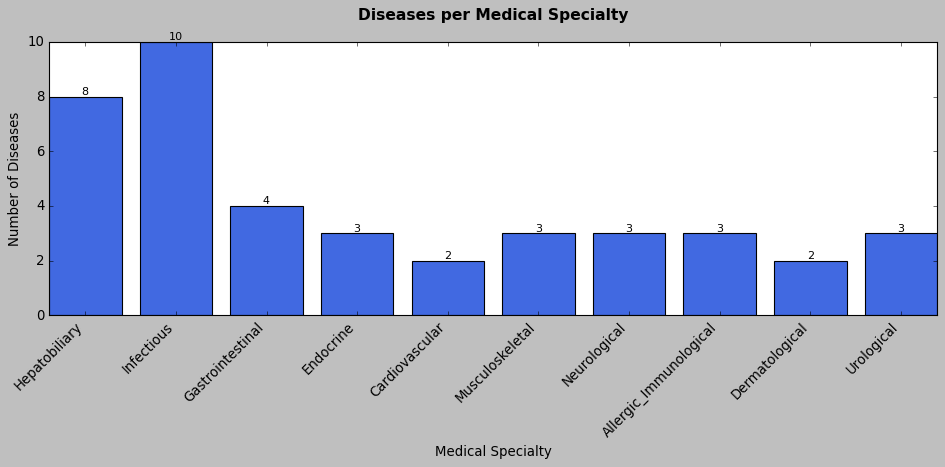

In [ ]:
# Create visualizer
visualizer = MedicalDiagnosisVisualizer(pipeline)

# Generate visualizations
visualizer.plot_medical_groups_sunburst()

In [ ]:
visualizer.plot_diseases_per_specialty()

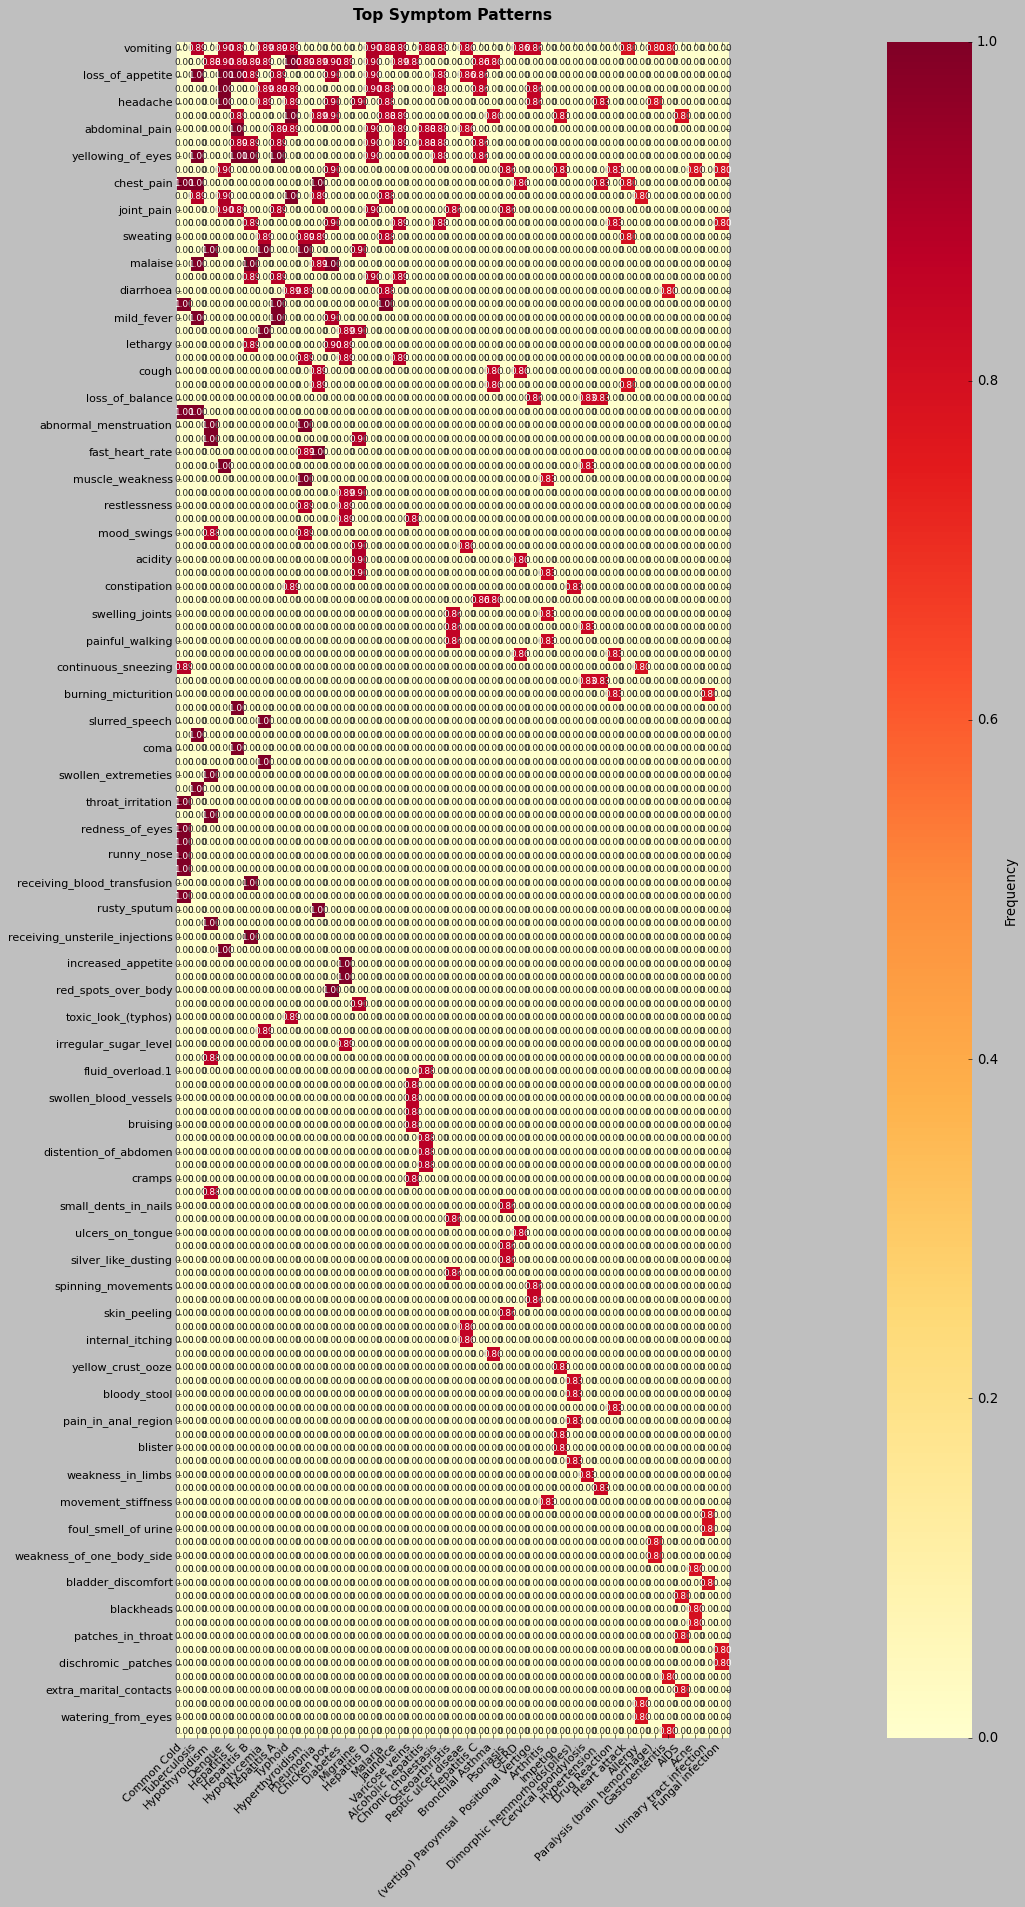

In [70]:
visualizer.plot_symptom_patterns(figsize=(40,24))

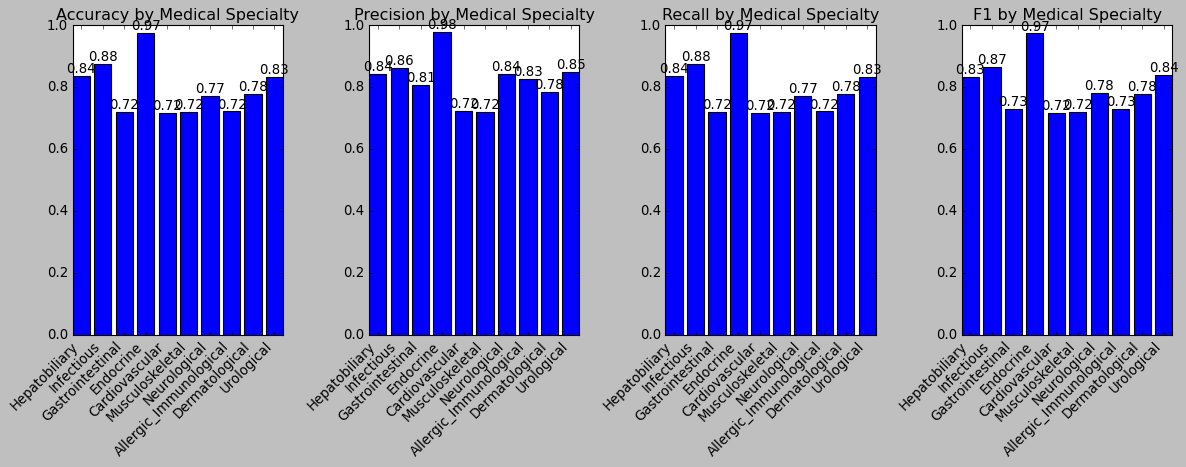

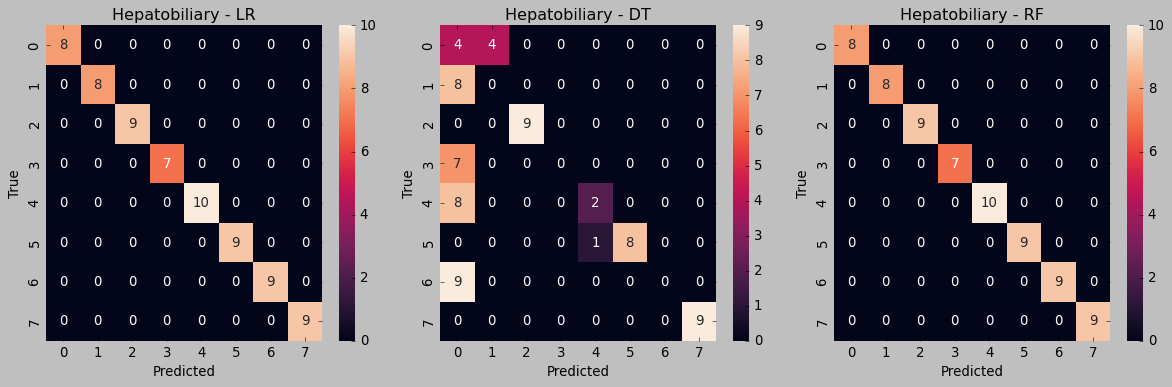

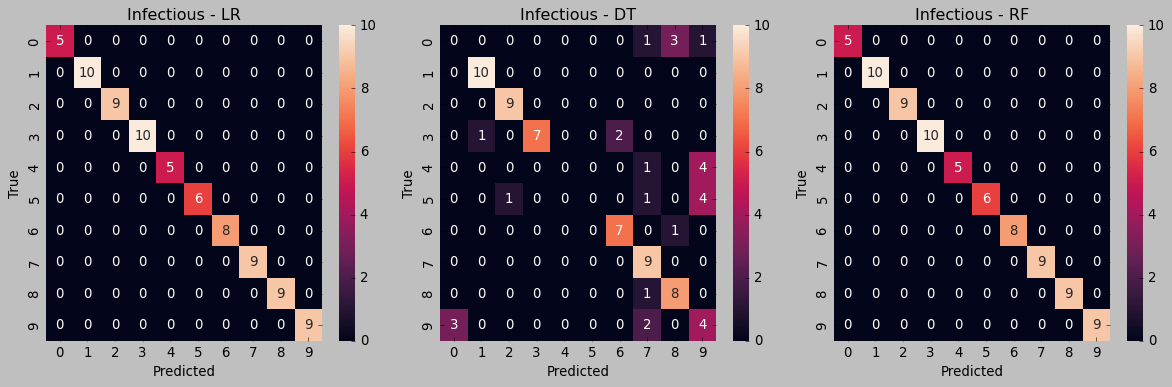

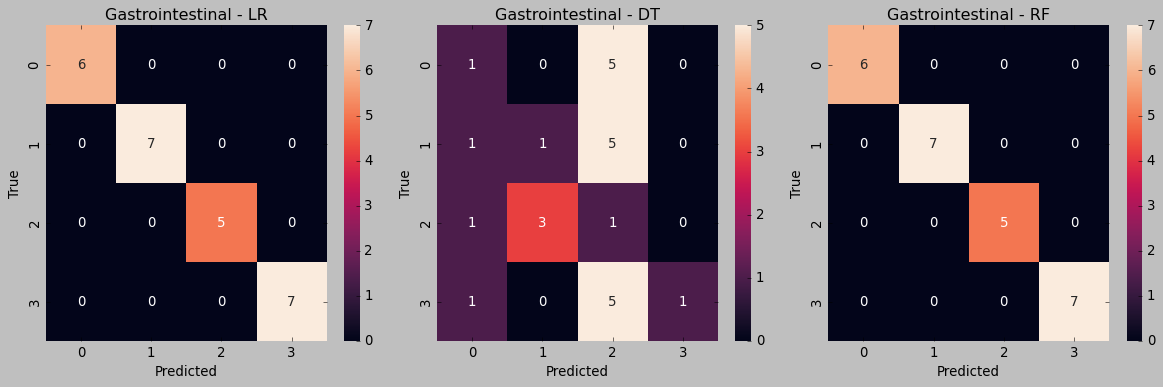

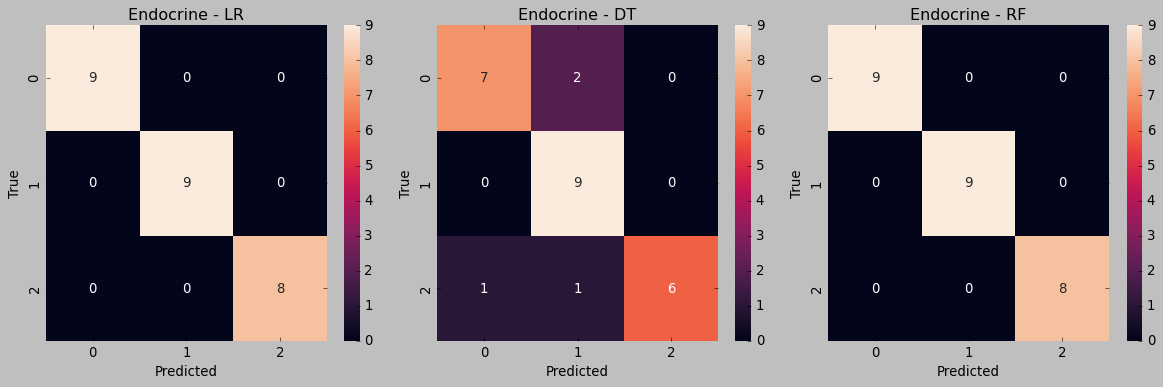

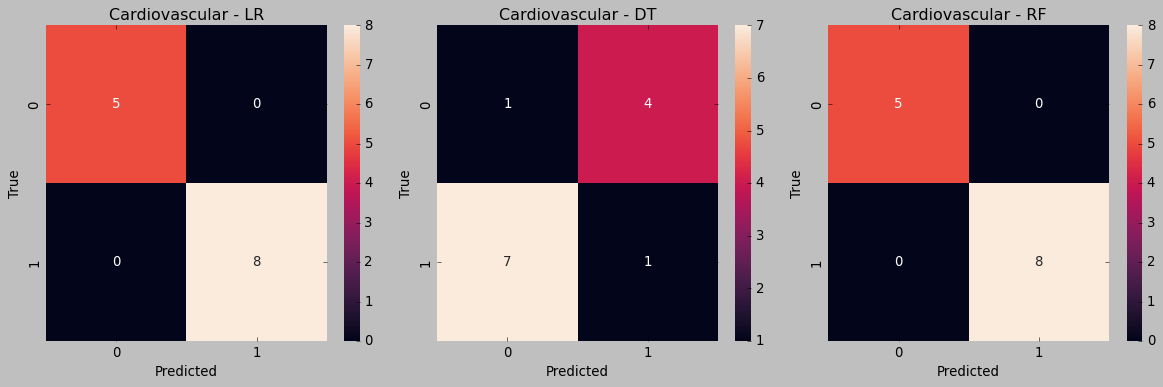

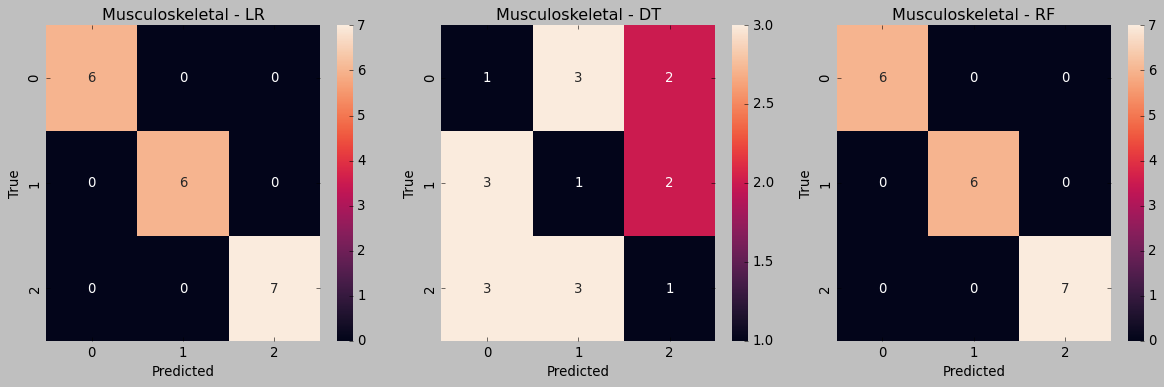

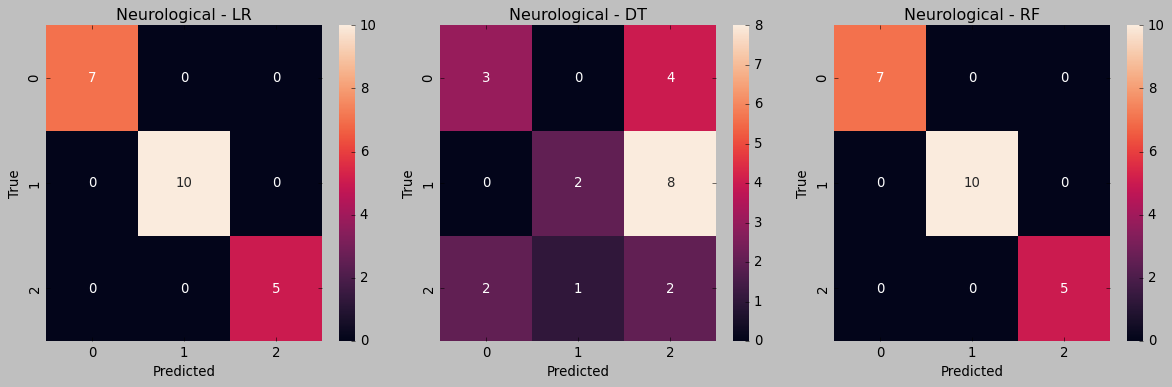

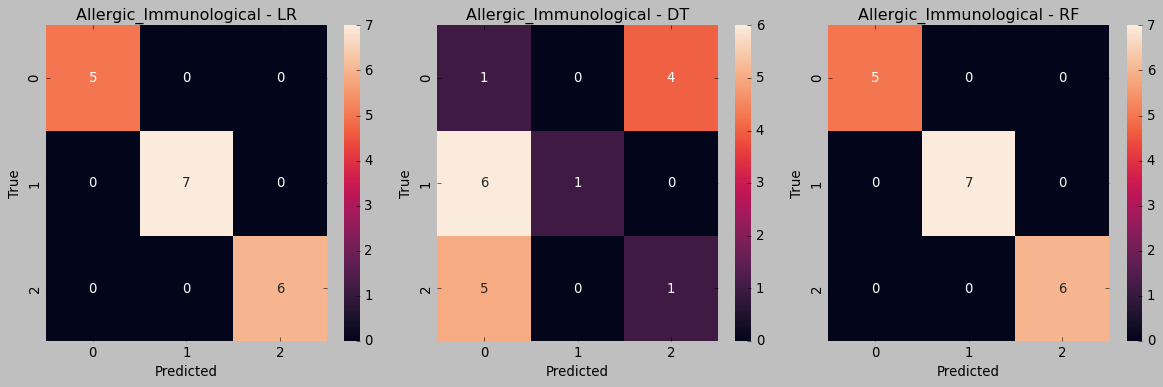

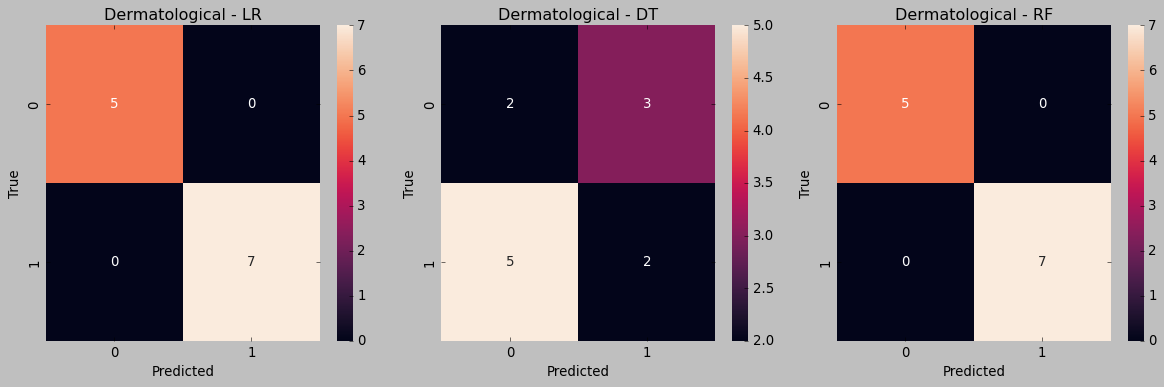

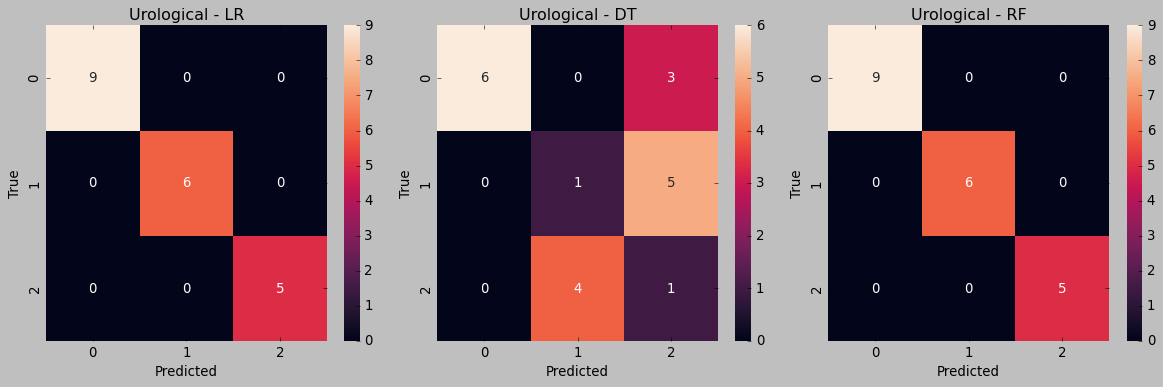

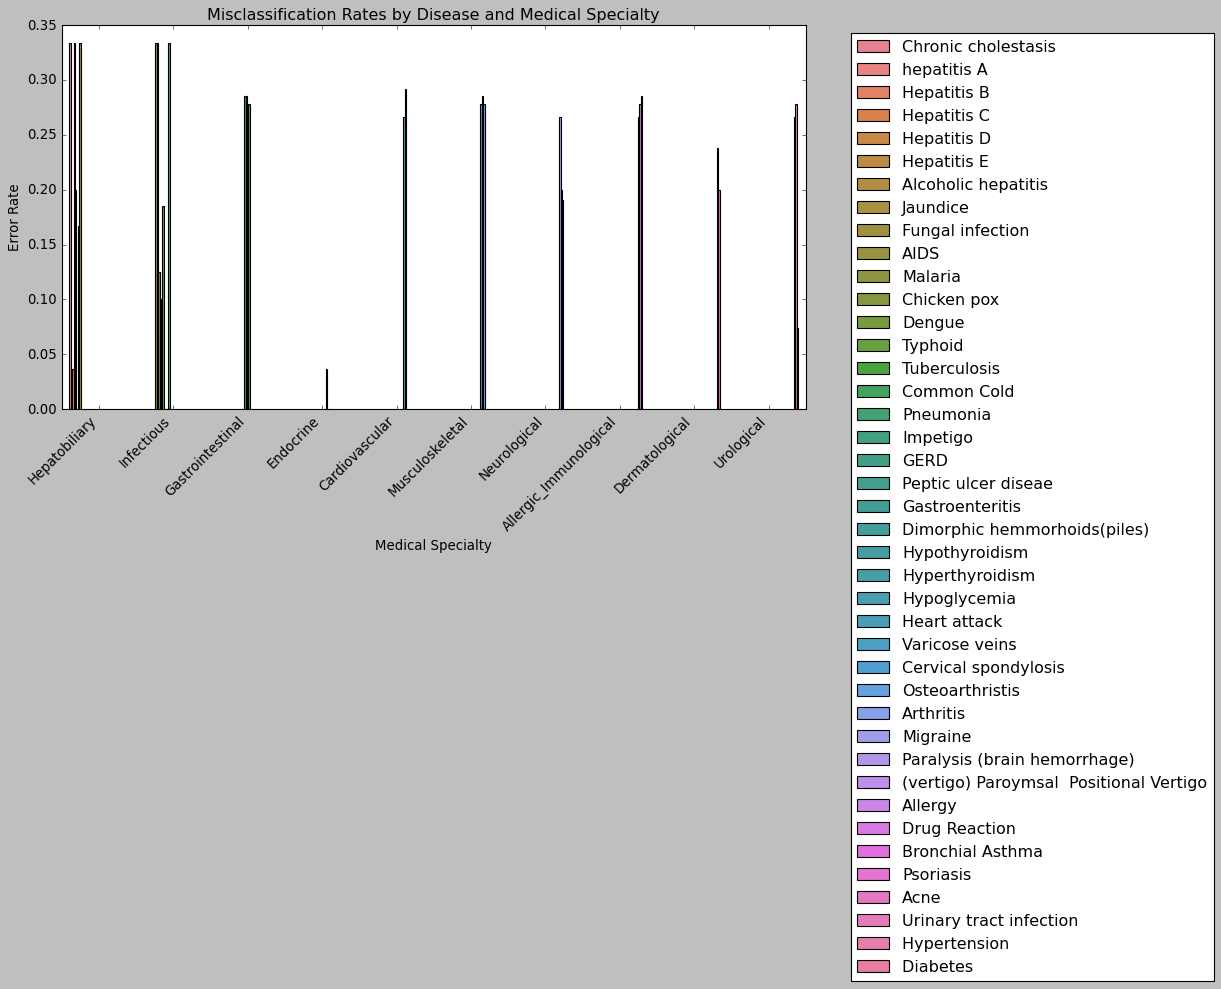

In [63]:
visualizer.plot_group_performance()
visualizer.plot_confusion_matrices()
visualizer.plot_misclassification_analysis()

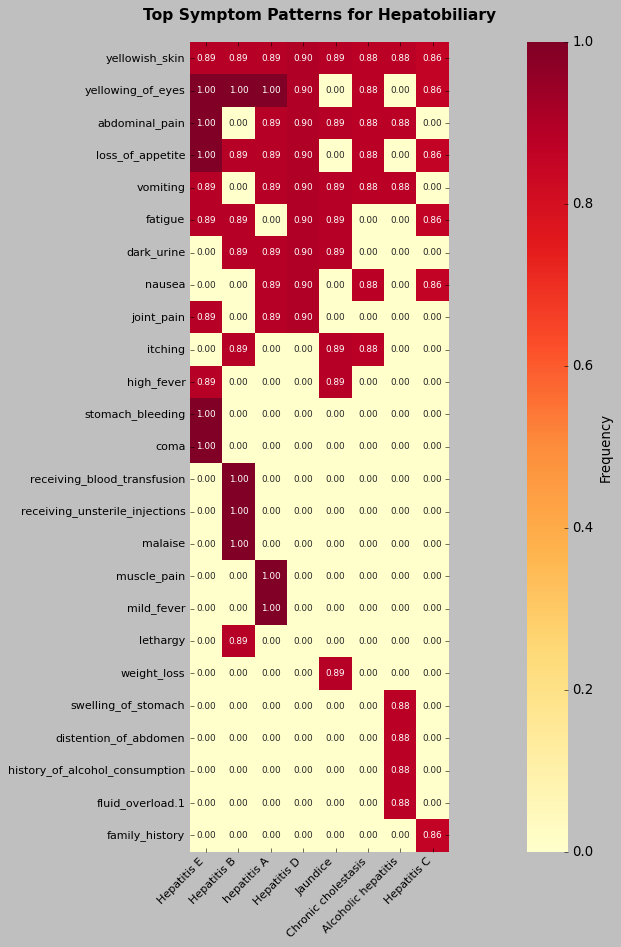

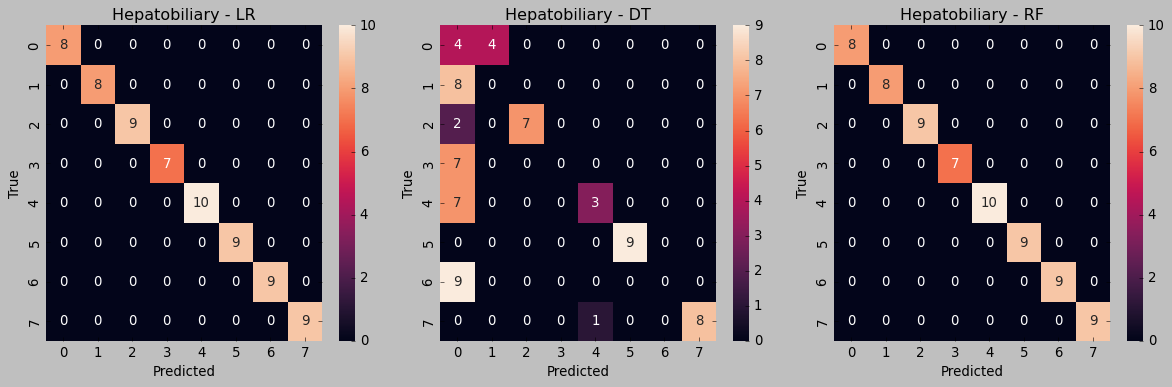

In [68]:
# For specific group analysis
visualizer.plot_symptom_patterns(group_name='Hepatobiliary')
visualizer.plot_confusion_matrices(group_name='Hepatobiliary')

Key recommendations given our small dataset:

1. Don't use traditional cross-validation - use Leave-One-Out validation instead
1. Avoid complex models that can easily overfit
1. Consider using ensemble of simpler models (e.g., logistic regression, simple decision trees)
1. Focus on identifying stable patterns rather than achieving perfect classification
1. Group similar diseases based on symptom patterns to create a hierarchical classification approach
1. Use bootstrap aggregating for more stable feature importance estimation